# TransformerLens: Introduction

## Setup

In [ ]:
import os
import sys
import plotly.express as px
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import einops
from jaxtyping import Int, Float
from typing import List, Optional, Tuple
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part2_intro_to_mech_interp"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from arena3.chapter1_transformer_interp.exercises.plotly_utils import imshow, hist, plot_comp_scores, plot_logit_attribution, plot_loss_difference
from part1_transformer_from_scratch.solutions import get_log_probs
import part2_intro_to_mech_interp.tests as tests

# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

device = t.device("cuda" if t.cuda.is_available() else "cpu")
t.cuda.empty_cache()

MAIN = __name__ == "__main__"

## Loading and Running Models

In [ ]:
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")

# Can instead define a model via   HookedTransformer.from_config(cfg)

print(gpt2_small.cfg)

In [ ]:
model_description_text = '''## Loading Models

HookedTransformer comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. Each model is loaded into the consistent HookedTransformer architecture, designed to be clean, consistent and interpretability-friendly.

For this demo notebook we'll look at GPT-2 Small, an 80M parameter model. To try the model the model out, let's find the loss on this paragraph!'''

loss = gpt2_small(model_description_text, return_type="loss")
print("Model loss:", loss)

## Tokenisation

In [ ]:
print(gpt2_small.to_str_tokens("gpt2"))
print()
print(gpt2_small.to_str_tokens(["gpt2", "gpt2"]))
print()
print(gpt2_small.to_tokens("gpt2"))
print()
print(gpt2_small.to_string([50256, 70, 457, 17]))

### Exercise: model performance

In [ ]:
logits = gpt2_small(model_description_text, return_type="logits")
prediction = logits.argmax(dim=-1).squeeze()[:-1]
expected = gpt2_small.to_tokens(model_description_text).squeeze()[1:]
num_correct = (prediction == expected).sum()

print(f"Correctly identified {num_correct}/{len(expected)}, or {num_correct/len(expected)*100:.2f}% of tokens. Correct tokens:")
print(f"{gpt2_small.to_str_tokens(prediction[prediction == expected])}")

## Caching all Activations

In [ ]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = gpt2_small.to_tokens(gpt2_text)
gpt2_logits, gpt2_cache = gpt2_small.run_with_cache(gpt2_tokens, remove_batch_dim=True)

print(gpt2_cache.keys())

In [ ]:
attn_patterns_layer_0 = gpt2_cache["pattern", 0] # shorthand

attn_patterns_layer_0_copy = gpt2_cache["blocks.0.attn.hook_pattern"] # direct cache indexing

t.testing.assert_close(attn_patterns_layer_0, attn_patterns_layer_0_copy)

### Exercise:   Verify Activations

In [ ]:
layer0_pattern_from_cache = gpt2_cache["pattern", 0]

layer0_attn_scores = einops.einsum(gpt2_cache["q", 0], gpt2_cache["k", 0], "seqQ n h, seqK n h -> n seqQ seqK")

mask = t.triu(t.ones_like(layer0_attn_scores, dtype=bool), diagonal=1).to(device)

layer0_attn_scores[mask] = -1.0e9
layer0_pattern_from_q_and_k = (layer0_attn_scores / gpt2_small.cfg.d_head**0.5).softmax(dim=-1)

t.testing.assert_close(layer0_pattern_from_cache, layer0_pattern_from_q_and_k)
print("Tests passed!")

# Visualising Attention Heads

In [ ]:
print(type(gpt2_cache))
attention_pattern = gpt2_cache["pattern", 0]
print(attention_pattern.shape)
gpt2_str_tokens = gpt2_small.to_str_tokens(gpt2_text)

print("Layer 0 Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=gpt2_str_tokens, 
    attention=attention_pattern,
    attention_head_names=[f"L0H{i}" for i in range(12)],
))

## Visualising Neuron Activations 

In [ ]:
neuron_activations_for_all_layers = t.stack([
    gpt2_cache["post", layer] for layer in range(gpt2_small.cfg.n_layers)
], dim=1)
# shape = (seq_pos, layers, neurons)

cv.activations.text_neuron_activations(
    tokens=gpt2_str_tokens,
    activations=neuron_activations_for_all_layers
)

In [ ]:
neuron_activations_for_all_layers_rearranged = utils.to_numpy(einops.rearrange(neuron_activations_for_all_layers, "seq layers neurons -> 1 layers seq neurons"))

cv.topk_tokens.topk_tokens(
    # Some weird indexing required here ¯\_(ツ)_/¯
    tokens=[gpt2_str_tokens], 
    activations=neuron_activations_for_all_layers_rearranged,
    max_k=7, 
    first_dimension_name="Layer", 
    third_dimension_name="Neuron",
    first_dimension_labels=list(range(12))
)

# Finding induction heads

## Toy Attention-Only Model

In [ ]:
cfg = HookedTransformerConfig(
    d_model=768,
    d_head=64,
    n_heads=12,
    n_layers=2,
    n_ctx=2048,
    d_vocab=50278,
    attention_dir="causal",
    attn_only=True, # defaults to False
    tokenizer_name="EleutherAI/gpt-neox-20b", 
    seed=398,
    use_attn_result=True,
    normalization_type=None, # defaults to "LN", i.e. layernorm with weights & biases
    positional_embedding_type="shortformer"
)

In [ ]:
from huggingface_hub import hf_hub_download

REPO_ID = "callummcdougall/attn_only_2L_half"
FILENAME = "attn_only_2L_half.pth"

weights_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

In [ ]:
model = HookedTransformer(cfg)
pretrained_weights = t.load(weights_path, map_location=device)
model.load_state_dict(pretrained_weights)

### Exercise: visualise attention patterns

In [ ]:
text = "We think that powerful, significantly superhuman machine intelligence is more likely than not to be created this century. If current machine learning techniques were scaled up to this level, we think they would by default produce systems that are deceptive or manipulative, and that no solid plans are known for how to avoid this."
logits, cache = model.run_with_cache(text, remove_batch_dim=True)

str_tokens = model.to_str_tokens(text)
for layer_idx in range(model.cfg.n_layers):
    attention_pattern = cache["pattern", layer_idx]
    display(cv.attention.attention_heads(tokens=str_tokens, attention=attention_pattern))

### Exercise: write own detectors

In [ ]:
THRESH = 0.4

def current_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be current-token heads
    '''
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            score = attention_pattern.diagonal().mean()
            if score > THRESH:
                attn_heads.append(f"{layer}.{head} ({score:.4f})")
    return attn_heads

def prev_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be prev-token heads
    '''
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            score = attention_pattern.diagonal(-1).mean()
            if score > THRESH:
                attn_heads.append(f"{layer}.{head} ({score:.4f})")
    return attn_heads

def first_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be first-token heads
    '''
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            score = attention_pattern[:, 0].mean()
            if score > THRESH:
                attn_heads.append(f"{layer}.{head} ({score:.4f})")
    return attn_heads

In [ ]:
print("Heads attending to current token  = ", ", ".join(current_attn_detector(cache)))
print("Heads attending to previous token = ", ", ".join(prev_attn_detector(cache)))
print("Heads attending to first token    = ", ", ".join(first_attn_detector(cache)))

#### Different text:

In [ ]:
text2 = "The goal of mechanistic interpretability is to take a trained model and reverse engineer the algorithms the model learned during training from its weights. It is a fact about the world today that we have computer programs that can essentially speak English at a human level (GPT-3, PaLM, etc), yet we have no idea how they work nor how to write one ourselves. This offends me greatly, and I would like to solve this! Mechanistic interpretability is a very young and small field, and there are a lot of open problems - if you would like to help, please try working on one!"
logits2, cache2 = model.run_with_cache(text2, remove_batch_dim=True)

# str_tokens2 = model.to_str_tokens(text2)
# for layer_idx in range(model.cfg.n_layers):
#     attention_pattern = cache["pattern", layer_idx]
#     display(cv.attention.attention_heads(tokens=str_tokens2, attention=attention_pattern))

print("Heads attending to current token  = ", ", ".join(current_attn_detector(cache2)))
print("Heads attending to previous token = ", ", ".join(prev_attn_detector(cache2)))
print("Heads attending to first token    = ", ", ".join(first_attn_detector(cache2)))

**!!! Same heads !!!** Similar scores.

## Checking for the induction capability

### Exercise: plot per-token loss on repeated sequence

In [ ]:
def generate_repeated_tokens(
    model: HookedTransformer, seq_len: int, batch: int = 1
) -> Int[Tensor, "batch full_seq_len"]:
    '''
    Generates a sequence of repeated random tokens

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
    '''
    prefix = (t.ones(batch, 1) * model.tokenizer.bos_token_id).long().to(device)
    tokens = t.randint(0, model.cfg.d_vocab, (batch, seq_len), dtype=t.long, device=device)
    return t.cat([prefix, tokens, tokens], dim=-1).to(device)

def run_and_cache_model_repeated_tokens(model: HookedTransformer, seq_len: int, batch: int = 1) -> Tuple[t.Tensor, t.Tensor, ActivationCache]:
    '''
    Generates a sequence of repeated random tokens, and runs the model on it, returning logits, tokens and cache

    Should use the `generate_repeated_tokens` function above

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
        rep_logits: [batch, 1+2*seq_len, d_vocab]
        rep_cache: The cache of the model run on rep_tokens
    '''
    # SOLUTION
    tokens = generate_repeated_tokens(model, seq_len, batch)
    logits, cache = model.run_with_cache(tokens)
    return tokens, logits, cache


seq_len = 50
batch = 1
(rep_tokens, rep_logits, rep_cache) = run_and_cache_model_repeated_tokens(model, seq_len, batch)
rep_cache.remove_batch_dim()
rep_str = model.to_str_tokens(rep_tokens)
model.reset_hooks()
log_probs = get_log_probs(rep_logits, rep_tokens).squeeze()

print(f"Performance on the first half: {log_probs[:seq_len].mean():.3f}")
print(f"Performance on the second half: {log_probs[seq_len:].mean():.3f}")

plot_loss_difference(log_probs, rep_str, seq_len)

### Looking for Induction Attention Patterns

In [ ]:
for layer in range(model.cfg.n_layers):
    attention_pattern = rep_cache["pattern", layer]
    display(cv.attention.attention_heads(tokens=rep_str, attention=attention_pattern))

### Exercise: make an induction detector

In [ ]:
print(rep_cache['hook_embed'].shape)

In [ ]:
def induction_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be induction heads

    Remember - the tokens used to generate rep_cache are (bos_token, *rand_tokens, *rand_tokens)
    '''
    # "'1 - ' because we're attending to the token *following* previous occurence of the current token"
    offset = 1 - ((cache["hook_embed"].shape[0] - 1) // 2)
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            score = attention_pattern.diagonal(offset=offset).mean()
            if score > 0.4:
                attn_heads.append(f"{layer}.{head}")
    return attn_heads


print("Induction heads = ", ", ".join(induction_attn_detector(rep_cache)))

# TransformerLens: Hooks

### Exercise: calculate induction scores with hooks

In [ ]:
seq_len = 50
batch = 10
rep_tokens_10 = generate_repeated_tokens(model, seq_len, batch)

# We make a tensor to store the induction score for each head.
# We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
induction_score_store = t.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)


def induction_score_hook(
    pattern: Float[Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    '''
    Calculates the induction score, and stores it in the [layer, head] position of the `induction_score_store` tensor.
    '''
    diag_offset = 1 - seq_len

    induction_score_store[hook.layer()][:] = pattern.diagonal(offset=diag_offset, dim1=-2, dim2=-1).mean(dim=(0, 2))

pattern_hook_names_filter = lambda name: name.endswith("pattern")

# Run with hooks (this is where we write to the `induction_score_store` tensor`)
model.run_with_hooks(
    rep_tokens_10, 
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

# Plot the induction scores for each head in each layer
imshow(
    induction_score_store, 
    labels={"x": "Head", "y": "Layer"}, 
    title="Induction Score by Head", 
    text_auto=".2f",
    width=900, height=400
)

### Exercise: find induction heads in GPT2-small

In [ ]:
def visualize_pattern_hook(
    pattern: Float[Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    print("Layer: ", hook.layer())
    display(
        cv.attention.attention_patterns(
            tokens=gpt2_small.to_str_tokens(rep_tokens[0]), 
            attention=pattern.mean(0)
        )
    )

In [ ]:
seq_len = 50
batch = 10
tokens = generate_repeated_tokens(gpt2_small, seq_len, batch)
print(f"Tokens: {tokens}")
print(f"Layers: {gpt2_small.cfg.n_layers}")
print(f"Heads: {gpt2_small.cfg.n_heads}")

induction_score_store = t.zeros((gpt2_small.cfg.n_layers, gpt2_small.cfg.n_heads), device=gpt2_small.cfg.device)

gpt2_small.run_with_hooks(
    tokens, 
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(
    induction_score_store, 
    labels={"x": "Head", "y": "Layer"},
    title="Induction Score by Head", 
    text_auto=".1f",
    width=800
)

Heads 5.1, 5.5, 6.9... strongly inductiony
Also check out 9.0 out of interest. 

In [ ]:
for induction_head_layer in [5, 9]:
    gpt2_small.run_with_hooks(
        rep_tokens, 
        return_type=None, # For efficiency, we don't need to calculate the logits
        fwd_hooks=[
            (utils.get_act_name("pattern", induction_head_layer), visualize_pattern_hook)
        ]
    )

## Building interpretability tools 

### Exercise: build logit attribution tool

In [ ]:
def logit_attribution(
    embed: Float[Tensor, "seq d_model"],
    l1_results: Float[Tensor, "seq nheads d_model"],
    l2_results: Float[Tensor, "seq nheads d_model"],
    W_U: Float[Tensor, "d_model d_vocab"],
    tokens: Int[Tensor, "seq"]
) -> Float[Tensor, "seq-1 n_components"]:
    '''
    Inputs:
        embed: the embeddings of the tokens (i.e. token + position embeddings)
        l1_results: the outputs of the attention heads at layer 1 (with head as one of the dimensions)
        l2_results: the outputs of the attention heads at layer 2 (with head as one of the dimensions)
        W_U: the unembedding matrix
        tokens: the token ids of the sequence

    Returns:
        Tensor of shape (seq_len-1, n_components)
        represents the concatenation (along dim=-1) of logit attributions from:
            the direct path (seq-1,1)
            layer 0 logits (seq-1, n_heads)
            layer 1 logits (seq-1, n_heads)
        so n_components = 1 + 2*n_heads
    '''
    seq_len_adj = tokens.shape[0] - 1
    W_U_correct_tokens = W_U[:, tokens[1:]]

    embed_out = einops.einsum(embed[:-1, :], W_U_correct_tokens, "seq_len_adj d_model, d_model seq_len_adj -> seq_len_adj")
    l1_out = einops.einsum(l1_results[:-1, :, :], W_U_correct_tokens, "seq_len_adj nheads d_model, d_model seq_len_adj -> seq_len_adj nheads")
    l2_out = einops.einsum(l2_results[:-1, :, :], W_U_correct_tokens, "seq_len_adj nheads d_model, d_model seq_len_adj -> seq_len_adj nheads")

    return t.cat([embed_out.unsqueeze(-1), l1_out, l2_out], dim=-1)


text = "We think that powerful, significantly superhuman machine intelligence is more likely than not to be created this century. If current machine learning techniques were scaled up to this level, we think they would by default produce systems that are deceptive or manipulative, and that no solid plans are known for how to avoid this."
logits, cache = model.run_with_cache(text, remove_batch_dim=True)
str_tokens = model.to_str_tokens(text)
tokens = model.to_tokens(text)

with t.inference_mode():
    embed = cache["embed"]
    l1_results = cache["result", 0]
    l2_results = cache["result", 1]
    logit_attr = logit_attribution(embed, l1_results, l2_results, model.W_U, tokens[0])
    # Uses fancy indexing to get a len(tokens[0])-1 length tensor, where the kth entry is the predicted logit for the correct k+1th token
    correct_token_logits = logits[0, t.arange(len(tokens[0]) - 1), tokens[0, 1:]]
    t.testing.assert_close(logit_attr.sum(1), correct_token_logits, atol=1e-3, rtol=0)
    print("Tests passed!")

Visualise logit attributions:

In [ ]:
embed = cache["embed"]
l1_results = cache["result", 0]
l2_results = cache["result", 1]
logit_attr = logit_attribution(embed, l1_results, l2_results, model.W_U, tokens[0])

plot_logit_attribution(model, logit_attr, tokens)

Observations:

1. Highest logit attribution comes from direct path (embed). High attributions in direct path are `| super|_7`, `| more|_12` `| machine|_24` and especially `| manip|_46`. Why? They are **offer very probably bigrams**. Examples are words split in two (e.g., "manipulative"), or words that are often paired with another. E.g., "more likely"

2. The second layer seems to contribute more than that first layer. Why? Attributions from a layer cannot pick up on a head's effect in composition within another head. Layer 0 therefore includes no compositional effects. In contrast, attributions for layer 1 heads do not only include the paths through those heads, but also the compositional path through layer 1 combined with heads in layer 0.  

### Exercise: logit attribution for the induction heads

In [ ]:
seq_len = 50

embed = rep_cache["embed"]
l1_results = rep_cache["result", 0]
l2_results = rep_cache["result", 1]
first_half_tokens = rep_tokens[0, : 1 + seq_len]
second_half_tokens = rep_tokens[0, seq_len:]

# (each with a single call to the `logit_attribution` function)
first_half_logit_attr = logit_attribution(embed[:seq_len+1], l1_results[:seq_len+1], l2_results[:seq_len+1], model.W_U, first_half_tokens)
second_half_logit_attr = logit_attribution(embed[seq_len:], l1_results[seq_len:], l2_results[seq_len:], model.W_U, second_half_tokens)

assert first_half_logit_attr.shape == (seq_len, 2*model.cfg.n_heads + 1)
assert second_half_logit_attr.shape == (seq_len, 2*model.cfg.n_heads + 1)

plot_logit_attribution(model, first_half_logit_attr, first_half_tokens, "Logit attribution (first half of repeated sequence)")
plot_logit_attribution(model, second_half_logit_attr, second_half_tokens, "Logit attribution (second half of repeated sequence)")

Interpretation:
1. Logit attribution for first hald of the sequence (first plot) is pretty meaningless. This sequence is random - no structure.
2. Previously, we observed that heads 1.4 and 1.10 seemed to be acting as induction heads. This plot gives further evidence that this is the case, since these two heads have a large logit attribution scores on sequences in which the only(?) way to get accurate predictions is to use the induction mechanism. Also, like our attention scores result, 1.10 is a stronger (induction) head than 1.4.

## Hooks: Intervening on Actions

### Ablations:
- Pick some part of the model and set it to zero.
- Crude proxy for how much it matters.
- If we believe a specific circuit in the model enables some capability, showing that ablating other parts does nothing can be strong evidence of this

### Exercise: induction head ablation

In [ ]:
def head_ablation_hook(
    v: Float[Tensor, "batch seq n_heads d_head"],
    hook: HookPoint,
    head_index_to_ablate: int
) -> Float[Tensor, "batch seq n_heads d_head"]:    
    '''
    A hook function that ablates the output of a single head.
    '''
    v[:, :, head_index_to_ablate] = 0.0
    return v 


def cross_entropy_loss(logits, tokens):
    '''
    Computes the mean cross entropy between logits (the model's prediction) and tokens (the true values).

    (optional, you can just use return_type="loss" instead.)
    '''
    log_probs = F.log_softmax(logits, dim=-1)
    pred_log_probs = t.gather(log_probs[:, :-1], -1, tokens[:, 1:, None])[..., 0]
    return -pred_log_probs.mean()


def get_ablation_scores(
    model: HookedTransformer, 
    tokens: Int[Tensor, "batch seq"]
) -> Float[Tensor, "n_layers n_heads"]:
    '''
    Returns a tensor of shape (n_layers, n_heads) containing the increase in cross entropy loss from ablating the output of each head.
    '''
    # Initialize an object to store the ablation scores
    ablation_scores = t.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)

    # Calculating loss without any ablation, to act as a baseline
    model.reset_hooks()
    logits = model(tokens, return_type="logits")
    seq_len = (tokens.shape[1] - 1) // 2
    loss_no_ablation = cross_entropy_loss(logits, tokens)
    loss_no_ablation = cross_entropy_loss(logits[:, -seq_len:], tokens[:, -seq_len:])

    for layer in tqdm(range(model.cfg.n_layers)):
        for head in range(model.cfg.n_heads):
            # Use functools.partial to create a temporary hook function with the head number fixed
            temp_hook_fn = functools.partial(head_ablation_hook, head_index_to_ablate=head)
            # Run the model with the ablation hook
            ablated_logits = model.run_with_hooks(tokens, fwd_hooks=[
                (utils.get_act_name("v", layer), temp_hook_fn)
            ])
            # Calculate the logit difference
            loss = cross_entropy_loss(ablated_logits[:, -seq_len:], tokens[:, -seq_len:])
            # Store the result, subtracting the clean loss so that a value of zero means no change in loss
            ablation_scores[layer, head] = loss - loss_no_ablation

    return ablation_scores


ablation_scores = get_ablation_scores(model, rep_tokens)
tests.test_get_ablation_scores(ablation_scores, model, rep_tokens)

In [ ]:
imshow(
    ablation_scores, 
    labels={"x": "Head", "y": "Layer", "color": "Logit diff"},
    title="Loss Difference After Ablating Heads", 
    text_auto=".2f",
    width=900, height=400
)

Interpretation:
- Since the input is a singly-repeated sequence of random characters, induction is a very important (the only?) mechanism of prediction.
- Therefore, ablation scores tell us which heads play an important role in the induction circuit.
- 0.7 is important: this was the strongest head attending to the previous token.
- 1.4 and 1.10 are important. These were the induction heads we identified earlier. Moreover, 1.10 has a higher score than 1.4, also agreeing with our previous observations of 1.10 being stronger.
- This result is more convincing than logit attribution alone, because it's *causal* 

### Bonus: try ablating everything except previous token head and two induction heads:

In [ ]:
def inductions_heads_ablation_hook(
    v: Float[Tensor, "batch seq n_heads d_head"],
    hook: HookPoint,
    ablation_type: str = "zero",
    inverse: bool = False
) -> Float[Tensor, "batch seq n_heads d_head"]:    
    '''
    A hook function that ablates the output of a single head.
    '''
    if hook.layer() == 0:
        head_idx = 7
    elif hook.layer() == 1:
        head_idx = t.tensor((4, 10), dtype=int, device=v.device)
    
    if inverse:
        heads = t.arange(model.cfg.n_heads)
        mask = t.ones_like(heads, dtype=bool).squeeze()
        mask[head_idx] = False
        head_idx = heads[mask]

    if ablation_type == "mean":
        v[:, :, head_idx] = v[:, :, head_idx].mean(dim=-1, keepdim=True)
    elif ablation_type == "zero":
        v[:, :, head_idx] = 0.0
    else:
        raise ValueError(f"Unknown ablation type: {ablation_type}")
    return v 

def run_model_with_ablation(temp_hook_fn):
    ablated_logits = model.run_with_hooks(tokens, fwd_hooks=[
        (utils.get_act_name("v", 0), temp_hook_fn),
        (utils.get_act_name("v", 1), temp_hook_fn)
    ])
    # Calculate the logit difference
    return cross_entropy_loss(ablated_logits[:, -seq_len:], tokens[:, -seq_len:])



def print_ablation_scores(
    model: HookedTransformer, 
    tokens: Int[Tensor, "batch seq"]
) -> Float[Tensor, "n_layers n_heads"]:
    '''
    Returns a tensor of shape (n_layers, n_heads) containing the increase in cross entropy loss from ablating the output of each head.
    '''

    # Calculating loss without any ablation, to act as a baseline
    model.reset_hooks()
    logits = model(tokens, return_type="logits")
    seq_len = (tokens.shape[1] - 1) // 2
    loss_no_ablation = cross_entropy_loss(logits, tokens)
    loss_no_ablation = cross_entropy_loss(logits[:, -seq_len:], tokens[:, -seq_len:])

    temp_hook_fn = functools.partial(inductions_heads_ablation_hook, ablation_type="zero", inverse=False)
    loss_diff = run_model_with_ablation(temp_hook_fn) - loss_no_ablation
    print(f"Ablations score if zero ablating just heads 0.7, 1.4, 1.10:\t{loss_diff:.3}")

    model.reset_hooks()
    temp_hook_fn = functools.partial(inductions_heads_ablation_hook, ablation_type="mean", inverse=False)
    loss_diff = run_model_with_ablation(temp_hook_fn) - loss_no_ablation
    print(f"Ablations score if mean ablating just heads 0.7, 1.4, 1.10:\t{loss_diff:.3}")

    model.reset_hooks()
    temp_hook_fn = functools.partial(inductions_heads_ablation_hook, ablation_type="zero", inverse=True)
    loss_diff = run_model_with_ablation(temp_hook_fn) - loss_no_ablation
    print(f"Ablations score if zero ablating all heads except 0.7, 1.4, 1.10:\t{loss_diff:.3}")

    model.reset_hooks()
    temp_hook_fn = functools.partial(inductions_heads_ablation_hook, ablation_type="mean", inverse=True)
    loss_diff = run_model_with_ablation(temp_hook_fn) - loss_no_ablation
    print(f"Ablations score if mean ablating all heads except  heads 0.7, 1.4, 1.10:\t{loss_diff:.3}")

    return ablation_scores

print_ablation_scores(model, rep_tokens)

In [ ]:
# TODO: verify above -> not really expected.

# Reverse-engineering induction circuits

## Factored Matrix class

### Exercise: deriving properties of a factored matrix *M = AB* (See [`FactoredMatrix` lib](https://github.com/neelnanda-io/TransformerLens/blob/main/transformer_lens/FactoredMatrix.py))

Compute trace of *M*

In [ ]:
A = t.tensor([[1, 2, 3], [4, 5, 6]])
B = t.tensor([[1, 2], [4, 5], [7, 8]])
M = A @ B

print(M)
print(M.trace())

print(einops.einsum(A, B, "i j, j i->"))


Compute eigenvalues of *M*:
- Note that `eig(AB)` == `eig(BA)`. **Pick smaller matrix**

Compute SVD of M:
- Note that SVD is *O(mn^2)*.
- See [`TransformerLens` implementation](https://github.com/neelnanda-io/TransformerLens/blob/760135a27c4b7873b0cb66aca541958f8939f60b/transformer_lens/FactoredMatrix.py#L158)

### Basic examples

In [ ]:
A = t.randn(5, 2)
B = t.randn(2, 5)
AB = A @ B
AB_factor = FactoredMatrix(A, B)
print("Norms:")
print(AB.norm())
print(AB_factor.norm())

print(f"Right dimension: {AB_factor.rdim}, Left dimension: {AB_factor.ldim}, Hidden dimension: {AB_factor.mdim}")

In [ ]:
print("Eigenvalues:")
print(t.linalg.eig(AB).eigenvalues)
print(AB_factor.eigenvalues)
print()
print("Singular Values:")
print(t.linalg.svd(AB).S)
print(AB_factor.S)
print("Full SVD:")
print(AB_factor.svd())

Note that, because the matrix is rank 2 but 5 by 5, the final 3 eigenvalues and singular values are zero (but present in `linalg.eig()` and `linalg.svd()` due to `float`) - the factored class omits the zeros.

Multiplication with other factored or unfactored matrices:

In [ ]:
C = t.randn(5, 300)
ABC = AB @ C
ABC_factor = AB_factor @ C
print("Unfactored:", ABC.shape, ABC.norm())
print("Factored:", ABC_factor.shape, ABC_factor.norm())
print(f"Right dimension: {ABC_factor.rdim}, Left dimension: {ABC_factor.ldim}, Hidden dimension: {ABC_factor.mdim}")

Use AB to get back to unfactored matrix:

In [ ]:
AB_unfactored = AB_factor.AB
t.testing.assert_close(AB_unfactored, AB)

## Reverse-engineering ciruits

### Exercise: compute OV circuit for head `1.4`

In [ ]:
layer = 1
head_index = 4

full_OV_circuit =  FactoredMatrix(model.W_E @ model.W_V[1, 4], model.W_O[1, 4] @ model.W_U)
print(full_OV_circuit)

tests.test_full_OV_circuit(full_OV_circuit, model, layer, head_index)

### Exercise: verify this is the identity

In [ ]:
full_OV_circuit_sample = full_OV_circuit[:200, :200].AB
imshow(
    full_OV_circuit_sample,
    labels={"x": "Input token", "y": "Logits on output token"},
    title="Full OV circuit for copying head",
    width=700,
)

Calculate "accuracy": what fraction of time is the diagonal element the largest logit in a row?

In [ ]:
def top_1_acc(full_OV_circuit: FactoredMatrix, batch_size: int = 1000) -> float:
    '''
    This should take the argmax of each column (ie over dim=0) and return the fraction of the time that's equal to the correct logit
    '''
    if isinstance(full_OV_circuit, FactoredMatrix):
        full_OV_circuit_unfactored = full_OV_circuit.AB.to(device=device)
    else:
        full_OV_circuit_unfactored = full_OV_circuit
    
    argmaxes = t.argmax(full_OV_circuit_unfactored, dim=1)
    expected = t.arange(full_OV_circuit_unfactored.shape[0], device=full_OV_circuit_unfactored.device)
    return t.sum(argmaxes == expected) / full_OV_circuit.shape[1]


print(f"Fraction of the time that the best logit is on the diagonal: {top_1_acc(full_OV_circuit):.4f}")

We actually have two induction heads! Recompute for the effective OV circuit for both:

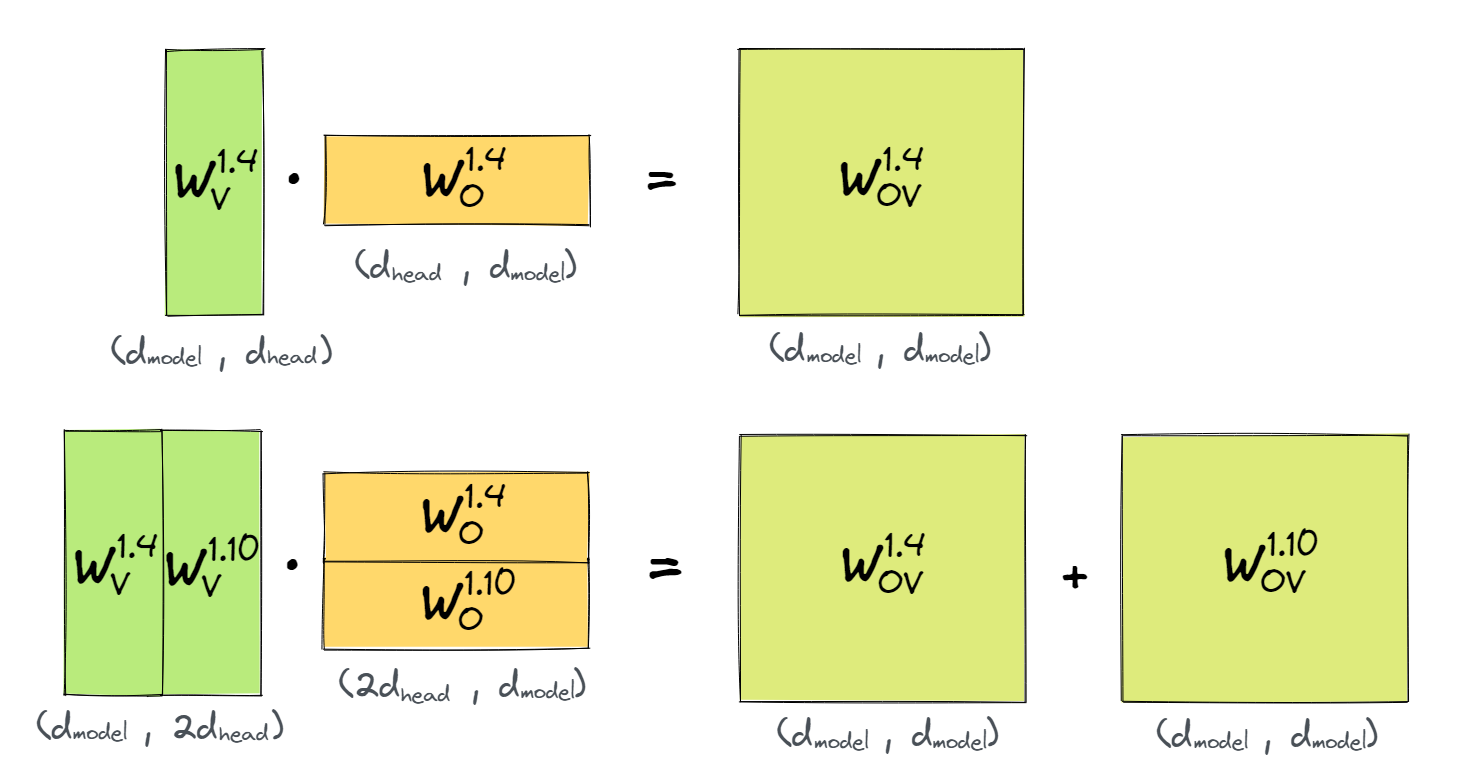

In [ ]:
W_O_vstack = einops.rearrange(model.W_O[1, [4, 10]], "head d_head d_model -> (head d_head) d_model")
W_V_hstack = einops.rearrange(model.W_V[1, [4, 10]], "head d_model d_head -> d_model (head d_head)")

full_OV_both = model.W_E @ FactoredMatrix(W_V_hstack, W_O_vstack) @ model.W_U

print(f"Fraction of the time that the best logit is on the diagonal: {top_1_acc(full_OV_both):.4f}")

##  QK prev-token circuit

In [ ]:
def mask_scores(attn_scores: Float[Tensor, "query_nctx key_nctx"]):
    '''Mask the attention scores so that tokens don't attend to previous tokens.'''
    assert attn_scores.shape == (model.cfg.n_ctx, model.cfg.n_ctx)
    mask = t.tril(t.ones_like(attn_scores)).bool()
    neg_inf = t.tensor(-1.0e6).to(attn_scores.device)
    masked_attn_scores = t.where(mask, attn_scores, neg_inf)
    return masked_attn_scores

layer = 0
head_index = 7
pos_by_pos_pattern = model.W_pos @ FactoredMatrix(model.W_Q[layer, head_index], model.W_K[layer, head_index].T) @ model.W_pos.T
pos_by_pos_pattern = mask_scores(pos_by_pos_pattern.AB) / model.cfg.d_head ** 0.5
pos_by_pos_pattern = pos_by_pos_pattern.softmax(dim=-1)

tests.test_pos_by_pos_pattern(pos_by_pos_pattern, model, layer, head_index)

## K-compositon circuit

Exercise: analyse the relative importance

In [ ]:
def decompose_qk_input(cache: ActivationCache) -> t.Tensor:
    '''
    Output is decomposed_qk_input, with shape [2+num_heads, seq, d_model]

    The [i, :, :]th element is y_i (from notation above)
    '''
    y0 = cache["embed"].unsqueeze(0)
    y1 = cache["pos_embed"].unsqueeze(0)
    y_heads = einops.rearrange(cache["result", 0], "seq head d_head -> head seq d_head")
    return t.cat([y0, y1, y_heads], dim=0)

def decompose_q(decomposed_qk_input: t.Tensor, ind_head_index: int) -> t.Tensor:
    '''
    Output is decomposed_q with shape [2+num_heads, position, d_head]

    The [i, :, :]th element is y_i @ W_Q (so the sum along axis 0 is just the q-values)
    '''
    return einops.einsum(decomposed_qk_input, model.W_Q[1, ind_head_index], "n seq d_model, d_model d_head -> n seq d_head")

def decompose_k(decomposed_qk_input: t.Tensor, ind_head_index: int) -> t.Tensor:
    '''
    Output is decomposed_k with shape [2+num_heads, position, d_head]

    The [i, :, :]th element is y_i @ W_K (so the sum along axis 0 is just the k-values)
    '''
    return einops.einsum(decomposed_qk_input, model.W_K[1, ind_head_index], "n seq d_model, d_model d_head -> n seq d_head")


ind_head_index = 4
# First we get decomposed q and k input, and check they're what we expect
decomposed_qk_input = decompose_qk_input(rep_cache)
decomposed_q = decompose_q(decomposed_qk_input, ind_head_index)
decomposed_k = decompose_k(decomposed_qk_input, ind_head_index)
t.testing.assert_close(decomposed_qk_input.sum(0), rep_cache["resid_pre", 1] + rep_cache["pos_embed"], rtol=0.01, atol=1e-05)
t.testing.assert_close(decomposed_q.sum(0), rep_cache["q", 1][:, ind_head_index], rtol=0.01, atol=0.001)
t.testing.assert_close(decomposed_k.sum(0), rep_cache["k", 1][:, ind_head_index], rtol=0.01, atol=0.01)
# Second, we plot our results
component_labels = ["Embed", "PosEmbed"] + [f"0.{h}" for h in range(model.cfg.n_heads)]
for decomposed_input, name in [(decomposed_q, "query"), (decomposed_k, "key")]:
    imshow(
        utils.to_numpy(decomposed_input.pow(2).sum([-1])), 
        labels={"x": "Position", "y": "Component"},
        title=f"Norms of components of {name}", 
        y=component_labels,
        width=1000, height=400
    )

### Exercise: decompose attention scores

In [ ]:
def decompose_attn_scores(decomposed_q: t.Tensor, decomposed_k: t.Tensor) -> t.Tensor:
    '''
    Output is decomposed_scores with shape [query_component, key_component, query_pos, key_pos]

    The [i, j, :, :]th element is y_i @ W_QK @ y_j^T (so the sum along both first axes are the attention scores)
    '''
    return einops.einsum(decomposed_q, decomposed_k, "q_comp q_pos d_head, k_comp k_pos d_head -> q_comp k_comp q_pos k_pos")


tests.test_decompose_attn_scores(decompose_attn_scores, decomposed_q, decomposed_k)

In [ ]:
decomposed_scores = decompose_attn_scores(decomposed_q, decomposed_k)
decomposed_stds = einops.reduce(
    decomposed_scores, 
    "query_decomp key_decomp query_pos key_pos -> query_decomp key_decomp", 
    t.std
)

# First plot: attention score contribution from (query_component, key_component) = (Embed, L0H7)
imshow(
    utils.to_numpy(t.tril(decomposed_scores[0, 9])), 
    title="Attention score contributions from (query, key) = (embed, output of L0H7)",
    width=800
)

# Second plot: std dev over query and key positions, shown by component
imshow(
    utils.to_numpy(decomposed_stds), 
    labels={"x": "Key Component", "y": "Query Component"},
    title="Standard deviations of attention score contributions (by key and query component)", 
    x=component_labels, 
    y=component_labels,
    width=800
)

### Exercise: compute the K-comp circuit